In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import seaborn as sns
import matplotlib
import graphviz 
from sklearn import __version__ as sklearn_version

In [2]:
print(pd.__version__)
print(sklearn_version)

1.0.5
0.23.1


In [3]:
df = pd.read_excel("data/Superstore.xls")

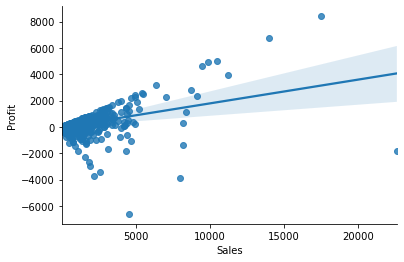

In [4]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine()

In [5]:
n_points = df.shape[0]
n_features = 2
x1=df['Sales'].values
x2=df['Profit'].values
x1 = x1 - x1.min()
x1 = x1/x1.max()

x2 = x2 - x2.min()
x2 = x2 / x2.max()

X=[[a,b] for (a,b) in zip(x1, x2)]
X=np.array(X)

# Isolation Tree

In [6]:
class Branch:
    no = 0
    depth = 1
    n_samples = 0
    split_feature_index = 0
    split_feature_value = 0

    left_branch = None
    right_branch = None
    isolated=False
    
    def __init__(self):
        self.n_samples=-1
    
    def is_leaf(self):
        return self.left_branch is None and self.right_branch is None

In [7]:
class IsolationTree():
    number=0
    max_depth=0
    tree=None
    
    def __init__(self,max_depth=3):
        self.number=0
        self.max_depth=max_depth
        
    def find_random_split(self, data):
        split_feature_index=int(np.random.random()*n_features)
        feature_values = data[:,split_feature_index]
        feature_min=feature_values.min()
        feature_max=feature_values.max()
        split_feature_value = feature_min+(feature_max-feature_min)*np.random.random()
        condition = feature_values <= split_feature_value

        left_data= data[condition,:]
        right_data = data[~condition,:]
        return split_feature_index, split_feature_value, right_data, left_data

    def decision_tree_inner(self, data, depth):
        branch = Branch()
        branch.no=self.number
        self.number=self.number+1
        branch.depth=depth

        branch.n_samples=data.shape[0]

        if branch.n_samples<2:
            
            branch.isolated=True
            return branch


        split_feature_index, split_feature_value, right_data, left_data = self.find_random_split(data)
        branch.split_feature_value=split_feature_value
        branch.split_feature_index=split_feature_index

        if depth==self.max_depth-1:
            # left
            left_branch=Branch()
            left_branch.no=self.number
            self.number=self.number+1
            left_branch.n_samples=left_data.shape[0]
            branch.left_branch=left_branch

            # right
            right_branch=Branch()
            right_branch.no=self.number
            self.number=self.number+1
            right_branch.n_samples=right_data.shape[0]
            branch.right_branch=right_branch
            return branch
        else:
            branch.left_branch=self.decision_tree_inner(left_data, depth+1)
            branch.right_branch=self.decision_tree_inner(right_data, depth+1)
            return branch

    def fit(self, X):
        self.number=0
        tree=self.decision_tree_inner(X, 0)
        self.tree=tree
        return tree
    
    def predict_one_inner(self, x, branch, length):
        
        if branch.is_leaf():
            return length
        
        length=length+1
        
        if x[branch.split_feature_index]<=branch.split_feature_value:
            # left branch
            return self.predict_one_inner(x, branch.left_branch, length)
        else:
            # right branch
            return self.predict_one_inner(x, branch.right_branch, length)
        
    def predict_one(self, x):
        return self.predict_one_inner(x, self.tree, 0)
    
    def predict(self, X):
        ys=[]
        for i in range(X.shape[0]):
            x=X[i]
            y=self.predict_one(x)
            ys.append(y)
        return np.array(ys)

In [53]:
class IsolationTreePainter2D():
    branch_colors=[]
    tab10_colors = plt.get_cmap('tab10')(np.arange(10, dtype=int))
    color_dict={}
    
    def __init__(self):
        self.branch_colors=[]
        self.color_dict={}
    
    
    def _draw_split(self, branch, x_limit=[0,1], y_limit=[0,1]):
        self.branch_colors.append(branch.no)

        si = branch.split_feature_index
        sv = branch.split_feature_value

        if si==0:
            plt.plot([sv, sv], y_limit, c=self.tab10_colors[len(self.branch_colors)-1 % 10])
            plt.annotate(str(branch.no), [sv, np.mean(y_limit)])
        else:
            plt.plot(x_limit, [sv, sv], c=self.tab10_colors[len(self.branch_colors)-1 % 10])
            plt.annotate(str(branch.no), [np.mean(x_limit), sv])

        if branch.left_branch is not None:
            if branch.left_branch.is_leaf():
                return
            if branch.split_feature_index==0:
                new_x_limit=[x_limit[0], sv]
                self._draw_split(branch.left_branch, new_x_limit, y_limit)
            else:
                new_y_limit=[y_limit[0], sv]
                self._draw_split(branch.left_branch, x_limit, new_y_limit)

        if branch.right_branch is not None:
            if branch.right_branch.is_leaf():
                return
            if branch.split_feature_index==0:
                new_x_limit=[sv, x_limit[1]]
                self._draw_split(branch.right_branch, new_x_limit, y_limit)
            else:
                new_y_limit=[sv, y_limit[1]]
                self._draw_split(branch.right_branch, x_limit, new_y_limit)

    def draw_split(self, branch):
        self.branch_colors=[]
        self._draw_split(branch, x_limit=[0,1], y_limit=[0,1])
        for i in range(len(self.branch_colors)):
            self.color_dict[self.branch_colors[i]]=self.tab10_colors[i]
    
    def get_dot_data_innner(self, branch:Branch, dot_data):

        if branch.isolated:
            dot_data=dot_data+f'{branch.no} [label=\"{branch.no}\\nsamples = {branch.n_samples}\\nIsolated :(\" , fillcolor="#FFFF3333"];\n'
        elif branch.is_leaf():
            dot_data=dot_data+f'{branch.no} [label=\"{branch.no}\\nsamples = {branch.n_samples}\" , fillcolor="#FFFFFFFF"];\n'  
        elif branch.no in self.branch_colors:
            hex_color = to_hex(self.color_dict[branch.no], keep_alpha=True)
            dot_data=dot_data+f'{branch.no} [label=\"{branch.no}\\n{branch.split_feature_index}<={branch.split_feature_value:0.2f}\\nsamples = {branch.n_samples}\" , fillcolor="{hex_color}"];\n'
        else:
            dot_data=dot_data+f'{branch.no} [label=\"{branch.no}\\n{branch.split_feature_index}<={branch.split_feature_value:0.2f}\\nsamples = {branch.n_samples}\" , fillcolor="#FFFFFFFF"];\n'

        if branch.left_branch:
            dot_data=dot_data+f'{branch.no} -> {branch.left_branch.no} [labeldistance=2.5, labelangle=45, headlabel="yes"];\n'
            dot_data=self.get_dot_data_innner(branch.left_branch, dot_data)

        if branch.right_branch:
            dot_data=dot_data+f'{branch.no} -> {branch.right_branch.no} [labeldistance=2.5, labelangle=-45, headlabel="no"];\n'
            dot_data=self.get_dot_data_innner(branch.right_branch, dot_data)

        return dot_data

    def get_tree_dot_data(self, i_tree):
        dot_data="""
    digraph Tree {
    node [shape=box, style="filled, rounded", color="black", fontname=helvetica];
    edge [fontname=helvetica] ;
    """
        dot_data=self.get_dot_data_innner(i_tree.tree,  dot_data)
        dot_data=dot_data+'\r\n}'
        return dot_data

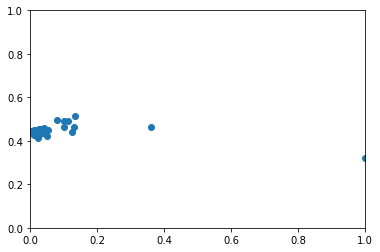

In [40]:
mask = np.random.choice([False, True], X.shape[0], p=[1-256/n_points, 256/n_points])

X_sub = X[mask,:]
plt.scatter(X_sub[:,0], X_sub[:,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [41]:
X_sub.shape[0]

227

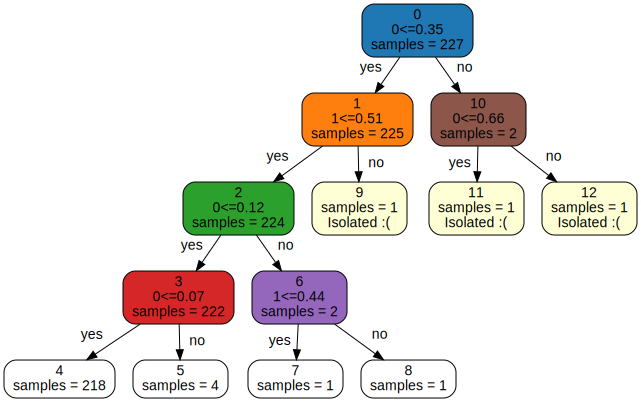

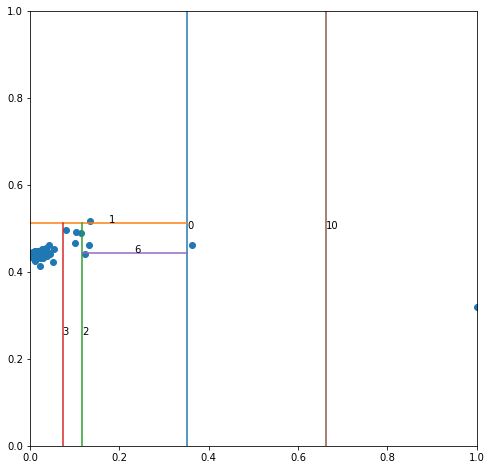

In [60]:
t=IsolationTree(max_depth=4)
t.fit(X_sub)

painter = IsolationTreePainter2D()
plt.figure(figsize=(8, 8))
plt.scatter(X_sub[:,0], X_sub[:,1])
plt.xlim([0,1])
plt.ylim([0,1])
painter.draw_split(t.tree)

dot_data=painter.get_tree_dot_data(t)
#dot_data=t.get_dot_data()
graph = graphviz.Source(dot_data) 
#graph.render('./data/my_dt', format='png')
graph

In [61]:
class IsolationForest(object):
    n_estimators=100
    threshold=0.0
    trees=[]
    lengths=[]
    
    def __init__(self, n_estimators=100):
        self.n_estimators=n_estimators
        self.trees=[]
        pass
    
    def fit(self, X):
        n_samples = X.shape[0]
        self.trees=[]
        for i in range(self.n_estimators):
            # according to the paper the best #subsamples is 256 and the depth is log(#subsamples) = 8
            # and the suggested number of trees is 100
            mask = np.random.choice([False, True], X.shape[0], p=[1-256/n_samples, 256/n_samples])
            X_sub = X[mask]
            it = IsolationTree(max_depth=8)
            it.fit(X_sub)
            self.trees.append(it)

        results=np.zeros((X.shape[0]))
        for i in range(self.n_estimators):
            y=self.trees[i].predict(X)
            results=results+y
        results=results/self.n_estimators
        self.lengths=np.array(results)
        self.threshold=np.percentile(results, 1)

        
    def decision_function(self, X):
        results=np.zeros((X.shape[0]))
        for i in range(self.n_estimators):
            y=self.trees[i].predict(X)
            results=results+y
        results=results/self.n_estimators
        #self.lengths=np.array(results)
        return results

    
    def predict(self, X):
        results=self.decision_function(X)
        return results<self.threshold

In [62]:
iforest=IsolationForest()
iforest.fit(X)

In [63]:
anomaly_labels=iforest.predict(X)

In [64]:
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X_mash = np.c_[xx.ravel(), yy.ravel()]
Z=iforest.decision_function(X_mash)
#Z = decision_function(X_mash, labels_mash)*-1
Z = Z.reshape(xx.shape)

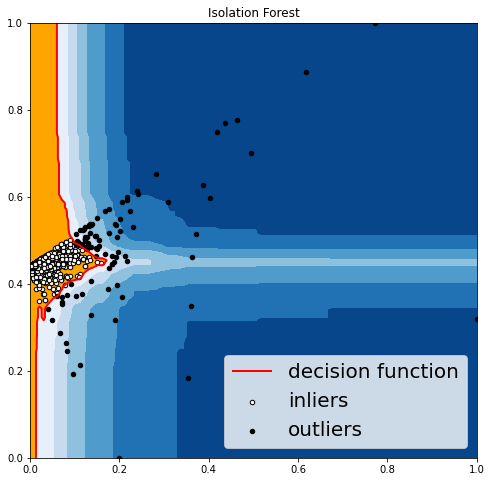

In [65]:


plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), iforest.threshold, 7),cmap=plt.cm.Blues_r)
plt.contourf(xx, yy, Z, levels=[iforest.threshold, Z.max(), ],colors='orange')
a=plt.contour(xx, yy, Z, levels=[iforest.threshold],linewidths=2, colors='red')
b=plt.scatter(x1[anomaly_labels==0], x2[anomaly_labels==0], c='white', s=20, edgecolor='k', label='Normal')
c=plt.scatter(x1[anomaly_labels==1], x2[anomaly_labels==1], c='black', s=20, label='Anormaly')
plt.legend([a.collections[0], b,c], ['decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right') 
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show()

# Isolation Score

$$H(n)=ln(n) + 0.5772156649$$
$$c(n) = 2H(n − 1) − (2(n − 1)/n)$$

Here 0.5772156649 is eular's constant. H(n) is harmonic number. and c is average length give the max length(n).

In [88]:
EULARS_CONSTANT=0.5772156649
def get_harmonic_number(n):
    return np.log(n)+EULARS_CONSTANT

def get_average_length(n):
    harmonic_number=np.log(n)+EULARS_CONSTANT
    return 2*get_harmonic_number(n-1) - (2*(n-1)/n)

In [114]:
get_average_length(256)

10.244770920116851

In [113]:
c8=get_average_length(8)
c8

3.2962516279106264

In [90]:
def get_score(path_length):
    return 2**-(path_length/c8)

In [111]:
df_score = pd.DataFrame()
df_score['average length(E)'] = [1, 2, 3,4,5,6,7,8]
scores=[]
for i in range(1, 9):
    #print(f'score will be {2**-(i/3.2962516279106264):0.2f} if average_length={i}')
    scores.append(2**-(i/3.2962516279106264))
df_score['score']=scores
df_score

,average length(E),score
0,1,0.810355
1,2,0.656674
2,3,0.532139
3,4,0.431221
4,5,0.349442
5,6,0.283172
6,7,0.229470
7,8,0.185952
